In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Read in all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
vocab_size = len(stoi)
vocab_size

27

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
g = torch.Generator().manual_seed(2147483647)

In [9]:
block_size = 3 # Context length

# Build the dataset
def build_dataset(words):
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("[",''.join(itos[i] for i in context),']', '--->', itos[ix])
            # print(','.join(str(i) for i in context))
            context = context[1:] + [ix] # Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# Let's train a deeper network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True)    # batch mean
            xvar = x.var(0, keepdim = True)    # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalise to unit variance
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# Dimensionality of the character embedding vectors
n_embd = 10 
# Number of neurons in the hidden layer of the MLP
n_hidden = 100

C = torch.randn((vocab_size, n_embd),                       generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), Tanh(),
    Linear(             n_hidden, vocab_size),
]

with torch.no_grad():
    # Last later: make less confident
    layers[-1].weight *= 0.1
    # All other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
    

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [14]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # Forward pass
    emb = C[Xb] # Embed the chars into vectors
    x = emb.view(emb.shape[0], -1) # Concatenate the vectors
    # Linear layer
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # Loss function


    # WITH BATCHNORM YOU DON'T NEED A BIAS!!!


    # BatchNorm layer!
    # bnmeani = hpreact.mean(0, keepdim=True)
    # bnstdi = hpreact.std(0, keepdim=True)
    # hpreact = bngain * (hpreact - bnmeani) / bnstdi  + bnbias
    # with torch.no_grad():
    #     bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    #     bnstd_running = 0.999 * bnmean_running + 0.001 * bnstdi

    

    # Non-linearity
        # Update mean & std
    # h = torch.tanh(hpreact) # Hidden layer
    # logits = h @ W2 + b2 # Output layer
    # loss = F.cross_entropy(logits, Yb) # Loss function

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.01 if i < 100000 / 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # Track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    if i == 20000:
        break
    
    


      0/ 200000: 1.8998
  10000/ 200000: 2.1831
  20000/ 200000: 2.4072


layer 1 (      Tanh): mean -0.02, std 0.79, saturated: 27.84%
layer 3 (      Tanh): mean -0.03, std 0.75, saturated: 17.38%
layer 5 (      Tanh): mean -0.03, std 0.73, saturated: 13.75%
layer 7 (      Tanh): mean -0.01, std 0.75, saturated: 14.44%
layer 9 (      Tanh): mean -0.02, std 0.76, saturated: 15.75%


Text(0.5, 1.0, 'activation distribution')

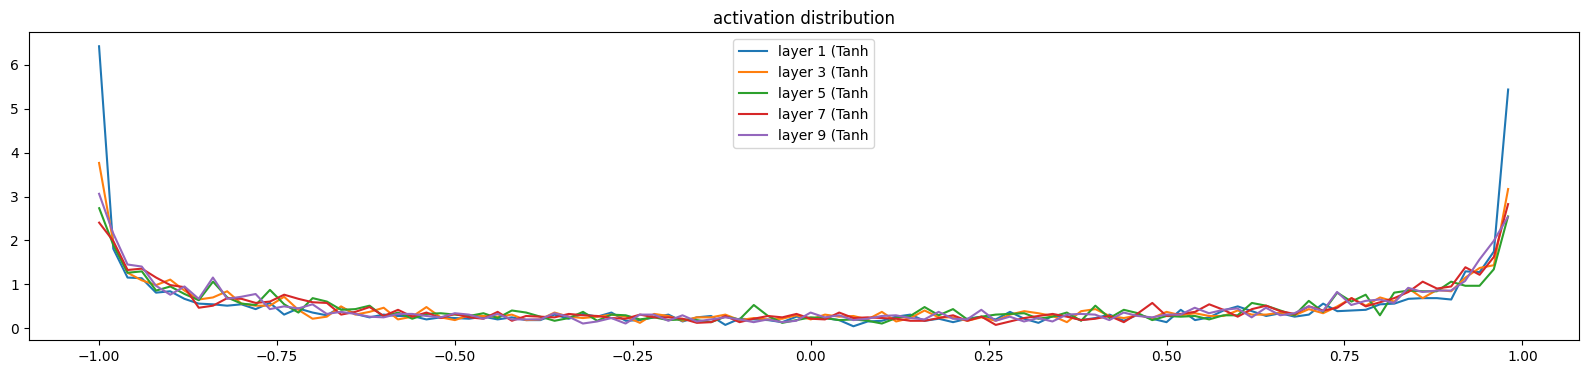

In [18]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 1 (      Tanh): mean -0.000026, std 5.838427e-03
layer 3 (      Tanh): mean +0.000021, std 5.972121e-03
layer 5 (      Tanh): mean +0.000028, std 5.419302e-03
layer 7 (      Tanh): mean -0.000035, std 5.176014e-03
layer 9 (      Tanh): mean -0.000152, std 4.664202e-03


Text(0.5, 1.0, 'gradient distribution')

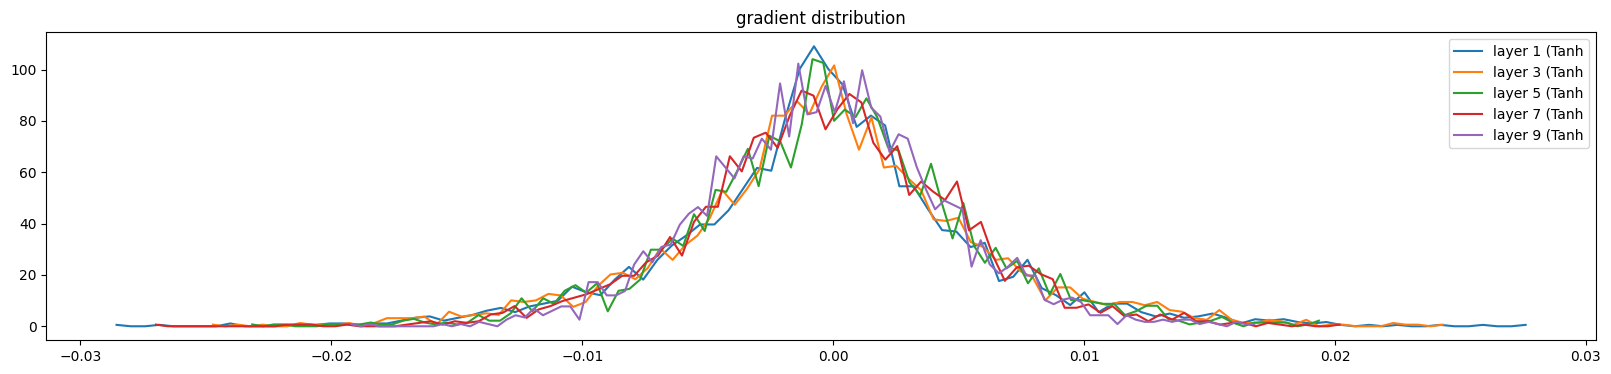

In [19]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')
